<a href="https://colab.research.google.com/github/RomainCendre/DSTest/blob/main/deepsense_generative_takehome_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Data modeling

Given the following [data-set](https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json).



In [14]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json")
data_1 = np.array(res.json())
print(data_1.shape)

(1542, 7)


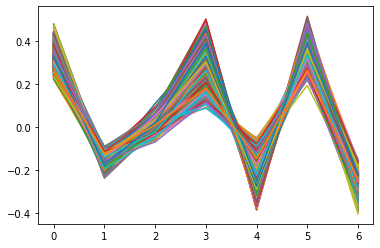

In [6]:
plt.plot(data1.T);

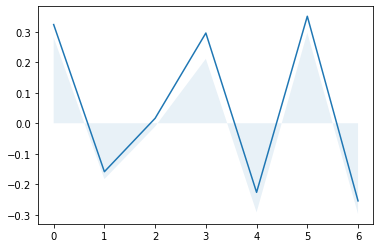

In [7]:
def mean_and_deviation(y):
    figure, axe = plt.subplots()
    x = range(y.shape[1])
    axe.plot(x, y.mean(axis=0))
    axe.fill_between(x, y.mean(axis=0) - y.std(axis=0), alpha=0.1)
    return figure
  
mean_and_deviation(data1);

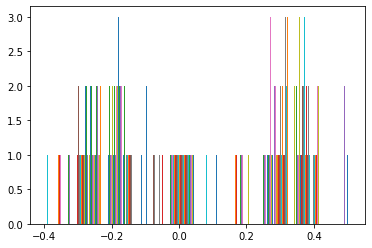

In [8]:
plt.hist(data1.T, bins=10);

### 1. Can you generate 10k rows of new data from the same distribution?
Following considered data as (n_samples, n_features) shape like most library does.

Depend on the purpose but this has been a long topic to counter imbalanced data annotation during the training phase. Nowadays, such ideas are not used only to counter imbalanced data issues, but also in classification topics when the number of data is insufficient.

I will distinguish two main categories :
*   Generation based on linear functions, basically consist in generating new sample by interpolation of existing data points (1990-2010)
*   Generation based on deep learning, with generative models (last decade)

In [32]:
nb_samples = 1000; # 1000 for test

#### LINEAR
##### Simple Interpolation


In [33]:
from random import random, randint

def generate_simple_interp(inputs, number):
  def interpolate(a, b, coeff):
    return a+(a-b)*coeff
  return np.array([interpolate(inputs[randint(0, len(inputs)-1)], inputs[randint(0, len(inputs)-1)], random()) for value in range(number)])

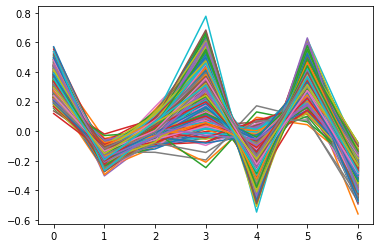

In [34]:
plt.plot(generate_simple_interp(data_1, nb_samples).T);

#### DEEP LEARNING


In [42]:
data_deep = np.expand_dims(data_1, axis=2) 

##### SIMPLE AE
For this, I will based the implementation on Keras, as compared to GAN, VAE are sequential approach.
From the repository of françois chollet from keras : https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

In [92]:
from keras import models,layers

def get_simple_ae():
    embedding_dim = 1 

    #Input layer
    input_img = layers.Input(shape=(data_1.shape[1],))  
    encoded = layers.Dense(embedding_dim, activation='relu')(input_img)
    decoded = layers.Dense(data_1.shape[1],activation='sigmoid')(encoded) 

    #Autoencoder --> in this API Model, we define the Input tensor and the output layer
    #wraps the 2 layers of Encoder e Decoder
    autoencoder = models.Model(input_img,decoded)
    autoencoder.summary()

    #Encoder
    encoder = models.Model(input_img,encoded)

    #Decoder
    encoded_input = layers.Input(shape=(embedding_dim,))
    decoder_layers = autoencoder.layers[-1]  #applying the last layer
    decoder = models.Model(encoded_input,decoder_layers(encoded_input))

    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')
    return autoencoder


In [93]:
def generate_simple_ae(inputs, number):
  autoencoder = get_simple_ae()
  history = autoencoder.fit(data_1, data_1, epochs=100, batch_size=256, 
                          shuffle=True, validation_split=0.1, 
                          callbacks=[ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
  return decoder.predict(np.random.rand(number, 1))

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 14        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-train

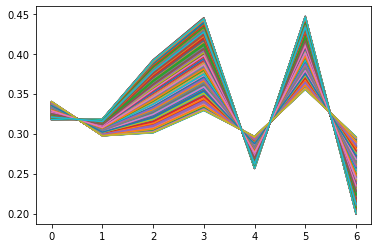

In [94]:
plt.plot(generate_simple_ae(data_1, nb_samples).T);

In [55]:
latent_dim = 1
"""
## Build the encoder
"""
encoder_inputs = keras.Input(shape=(data_deep.shape[1], data_deep.shape[2]))
x = layers.Conv1D(4, 3, activation="relu")(encoder_inputs)
z = layers.Dense(16, activation="relu")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

"""
## Build the decoder
"""
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Conv1DTranspose(64, 3, activation="relu")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

model = keras.Sequential(
    [
        layers.Input(shape=(data_deep.shape[1], data_deep.shape[2])),
        layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=3, padding="same", activation="relu"),
        layers.Conv1DTranspose(filters=16, kernel_size=3, padding="same", activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", activation="relu"),
        layers.Conv1DTranspose(filters=1, kernel_size=3, padding="same"),
    ]
)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 4)              16        
_________________________________________________________________
dense (Dense)                (None, 5, 16)             80        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored

##### VAE
For this, I will based the implementation on Keras, as compared to GAN, VAE are sequential approach.
From the repository of françois chollet from keras : https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 1
"""
## Build the encoder
"""
encoder_inputs = keras.Input(shape=(7, 1))
x = layers.Conv1D(4, activation="relu")(encoder_inputs)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Conv1DTranspose(64, 3, activation="relu")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


"""
## Train the VAE
"""
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data, epochs=30)

TypeError: ignored

## GAN

In [ ]:
data.shape


### 2. How could prior-knowledge help you in this task?

In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/IdrissMg/695f423af0f0aaffd8d69bc403932c6b/raw/6f3192bbcc328f2aa53ae2faef0cefb825564ea9/data_science_test.json")
data = np.array(res.json())

In [ ]:
# The data-set is properly loaded
print(data[:10,:])